## Logistic Regression Classifier 

This notebook contains the logistic regression classifier on the collected data.

Table of Content:
* **1. Import required packages**
* **2. Create functions**
* **3. Import files**
* **4. Data preparation**
* 4.1 Check for null values
* 4.2 Replace or drop null values
* **5. Descriptive analysis**
* 5.1 Average of numerical features
* 5.2 Check the imbalance in the target feature
* 5.3 Check the multicollinearity in the independent features
* **6. Undersampling the majority class**
* **7. PCA on the undersampling data**
* 7.1 Create scree plot
* 7.2 Fit the PCA based on scree plot
* 7.3 Check the multicollinearity in the PCA components
* **8. Building a logistic regression model on the transformed data**
* 8.1 Building the logistic regression on train/test split data
* 8.2 Get the modell coefficients
* 8.3 Visualization of the modell coefficients
* 8.4 Evaulation of the modell
* **9. Logistic regression without PCA**
* **10. Logistic regression without PCA and with significant variables**
* 10.1 Logistic Regression with Sklearn

### 1. Import required packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, confusion_matrix, r2_score, roc_auc_score, roc_curve

### 2. Create functions

In [5]:
# function for creating correlation matrix
def plot_corr(df, numerics, size = (15, 13)):
    
    fig, ax = plt.subplots(figsize = size)
    sns.heatmap(df[numerics].corr(), ax = ax, cmap = 'coolwarm', center = 0, 
                annot = True, fmt = '.1g', annot_kws={'size' : 8})
    plt.title('Correlations\n')
    plt.show()

In [6]:
# function for calculating VIF value for the independent features
def calculate_vif(X):
  vif = pd.DataFrame()
  vif["variables"] = X.columns
  vif["VIF"] = [variance_inflation_factor(X.values, i) for i in  range(X.shape[1])]
  return(vif)

### 3. Import files

In [7]:
abt_covid = pd.read_pickle('C:/Users/molna/Desktop/Szakdolgozat/adatok/abt_covid_featured.pkl')

print("ABT table has {} rows and {} columns".format(len(abt_covid), len(abt_covid.columns)))

ABT table has 63631 rows and 75 columns


In [8]:
# select only the relevant features for the modelling
abt_covid.drop(["title", "date", "text", "title_ner_pers", "title_ner_orgs",
                "title_cleaned", "text_cleaned", "title_tokens", "text_tokens",
                "title_lemmas", "text_lemmas", "title_pos", "text_pos",
                "title_ner_locs", "text_ner_pers", "text_ner_orgs", "text_ner_locs",
                "title_senti_list", "text_senti_list"], axis=1, inplace=True)

In [9]:
abt_covid.columns

Index(['source', 'dezinf', 'title_word_cnt', 'title_avg_word',
       'title_exclam_num', 'title_ques_num', 'title_stop_cnt',
       'title_cnt_upper', 'text_word_cnt', 'text_avg_word', 'text_ques_num',
       'text_exclam_num', 'text_stop_cnt', 'text_cnt_upper', 'text_cnt_num',
       'title_cnt_num', 'text_unique_lemma_ratio', 'title_cnt_unique_lemmas',
       'title_stop_word_ratio', 'text_cnt_unique_lemmas',
       'text_stop_word_ratio', 'title_noun_ratio', 'title_verb_ratio',
       'title_propn_ratio', 'title_adj_ratio', 'text_noun_ratio',
       'text_verb_ratio', 'text_propn_ratio', 'text_adj_ratio',
       'title_polarity', 'text_polarity', 'DIFF_title_word_cnt',
       'DIFF_title_avg_word', 'DIFF_title_exclam_num', 'DIFF_title_ques_num',
       'DIFF_title_stop_cnt', 'DIFF_title_cnt_upper', 'DIFF_title_cnt_num',
       'DIFF_title_cnt_unique_lemmas', 'DIFF_title_stop_word_ratio',
       'DIFF_title_verb_ratio', 'DIFF_title_propn_ratio',
       'DIFF_title_adj_ratio', 'DIFF_

### 4. Data preparation

#### 4.1 Check for null values

In [10]:
abt_covid[abt_covid.columns[abt_covid.isnull().any()]].isnull().sum()

title_stop_word_ratio    1
dtype: int64

#### 4.2 Replace or drop null values 

In [11]:
abt_covid['title_stop_word_ratio'].fillna((abt_covid['title_stop_word_ratio'].mean()), inplace=True)

In [12]:
abt_covid = abt_covid[~abt_covid.isin([np.nan, np.inf, -np.inf]).any(1)]

### 5. Descriptive analysis

#### 5.1 Average of numerical features

In [13]:
abt_covid.groupby("dezinf").mean()

,title_word_cnt,title_avg_word,title_exclam_num,title_ques_num,title_stop_cnt,title_cnt_upper,text_word_cnt,text_avg_word,text_ques_num,text_exclam_num,...,DIFF_text_ques_num,DIFF_text_stop_cnt,DIFF_text_cnt_upper,DIFF_text_cnt_num,DIFF_text_unique_lemma_ratio,DIFF_text_cnt_unique_lemmas,DIFF_text_stop_word_ratio,DIFF_text_noun_ratio,DIFF_text_verb_ratio,DIFF_text_propn_ratio
dezinf,,,,,,,,,,,,,,,,,,,,,
0,8.428171,6.639476,0.009691,0.025538,2.387302,0.197851,417.094110,6.537977,0.490547,0.345401,...,7.923449,-116.395232,0.556254,-23.738524,7.655628,-155.190756,7.739434,7.914372,8.280223,8.426675
1,13.925725,6.342914,0.676610,0.163766,3.365424,1.082486,268.648437,6.534336,0.558493,0.800000,...,13.421003,-110.897679,6.053807,-18.240970,13.153182,-149.693203,13.236988,13.411926,13.777777,13.924228


In [14]:
abt_covid.groupby("source").mean()

,dezinf,title_word_cnt,title_avg_word,title_exclam_num,title_ques_num,title_stop_cnt,title_cnt_upper,text_word_cnt,text_avg_word,text_ques_num,...,DIFF_text_ques_num,DIFF_text_stop_cnt,DIFF_text_cnt_upper,DIFF_text_cnt_num,DIFF_text_unique_lemma_ratio,DIFF_text_cnt_unique_lemmas,DIFF_text_stop_word_ratio,DIFF_text_noun_ratio,DIFF_text_verb_ratio,DIFF_text_propn_ratio
source,,,,,,,,,,,,,,,,,,,,,
alternativhirek.com,1.0,18.396135,6.348325,0.410628,0.120773,4.574879,0.714976,664.917874,6.480960,1.328502,...,17.891413,-106.427268,10.524217,-13.770560,17.623592,-145.222793,17.707398,17.882336,18.248187,18.394638
avilagtitkai.com,1.0,10.107769,6.384286,0.170426,0.192982,3.220551,0.280702,362.614035,6.388347,0.596491,...,9.603047,-114.715634,2.235852,-22.058926,9.335226,-153.511158,9.419032,9.593970,9.959821,10.106273
eztnezdmeg.com,1.0,13.411872,6.575923,0.274277,0.032268,3.164079,0.550076,186.738813,6.545528,0.136682,...,12.907150,-111.411532,5.539954,-18.754823,12.639329,-150.207056,12.723135,12.898073,13.263924,13.410375
fokusz.online,1.0,10.450495,6.180891,0.133663,0.064356,2.767327,0.386139,197.207921,6.366199,0.227723,...,9.945773,-114.372909,2.578577,-21.716200,9.677952,-153.168433,9.761758,9.936696,10.302547,10.448998
index.hu,0.0,8.266366,6.558494,0.010227,0.032450,2.406806,0.188005,417.682760,6.429845,0.550179,...,7.761643,-116.557038,0.394448,-23.900330,7.493823,-155.352562,7.577629,7.752566,8.118418,8.264869
kimondottigazsagok.com,1.0,12.560345,6.294859,0.226054,0.337165,3.420019,0.245690,274.064176,6.486913,1.128352,...,12.055622,-112.263059,4.688427,-19.606351,11.787802,-151.058583,11.871608,12.046545,12.412397,12.558848
minden-egyben.com,1.0,17.708117,6.311116,1.588371,0.198618,3.609384,3.029361,230.241796,6.586354,0.290731,...,17.203395,-107.115286,9.836200,-14.458578,16.935574,-145.910810,17.019380,17.194318,17.560169,17.706621
origo.hu,0.0,8.609276,6.730118,0.009091,0.017802,2.365473,0.208872,416.435251,6.659005,0.423804,...,8.104553,-116.214128,0.737358,-23.557420,7.836732,-155.009652,7.920539,8.095476,8.461327,8.607779
titkokszigete.hu,1.0,12.512658,6.322652,0.242232,0.274453,3.417722,0.231876,278.178941,6.462631,1.048907,...,12.007936,-112.310745,4.640740,-19.654037,11.740115,-151.106270,11.823921,11.998859,12.364710,12.511161


#### 5.2 Check the imbalance in the target feature

In [15]:
abt_covid["dezinf"].value_counts()

0    50356
1    13275
Name: dezinf, dtype: int64

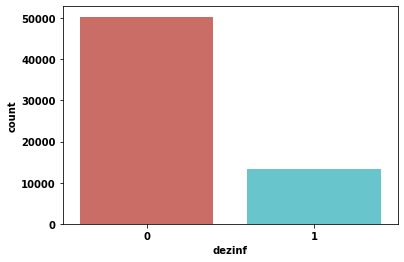

In [16]:
sns.countplot(x="dezinf", data=abt_covid, palette="hls")
plt.show()

In [17]:
abt_covid.drop(["source"], axis=1, inplace=True)

#### 5.3 Check the multicollinearity in the independent features

In [18]:
diff_from_mean_vars = [str for str in abt_covid.columns if any(sub in str for sub in ["DIFF_"])]

In [30]:
abt_covid_flat_vars = abt_covid.loc[:, ~abt_covid.columns.isin(diff_from_mean_vars)]
print(len(abt_covid_flat_vars.columns))

30


In [31]:
abt_covid_diff_vars = abt_covid.loc[:, abt_covid.columns.isin(diff_from_mean_vars)]
print(len(abt_covid_diff_vars.columns))

25


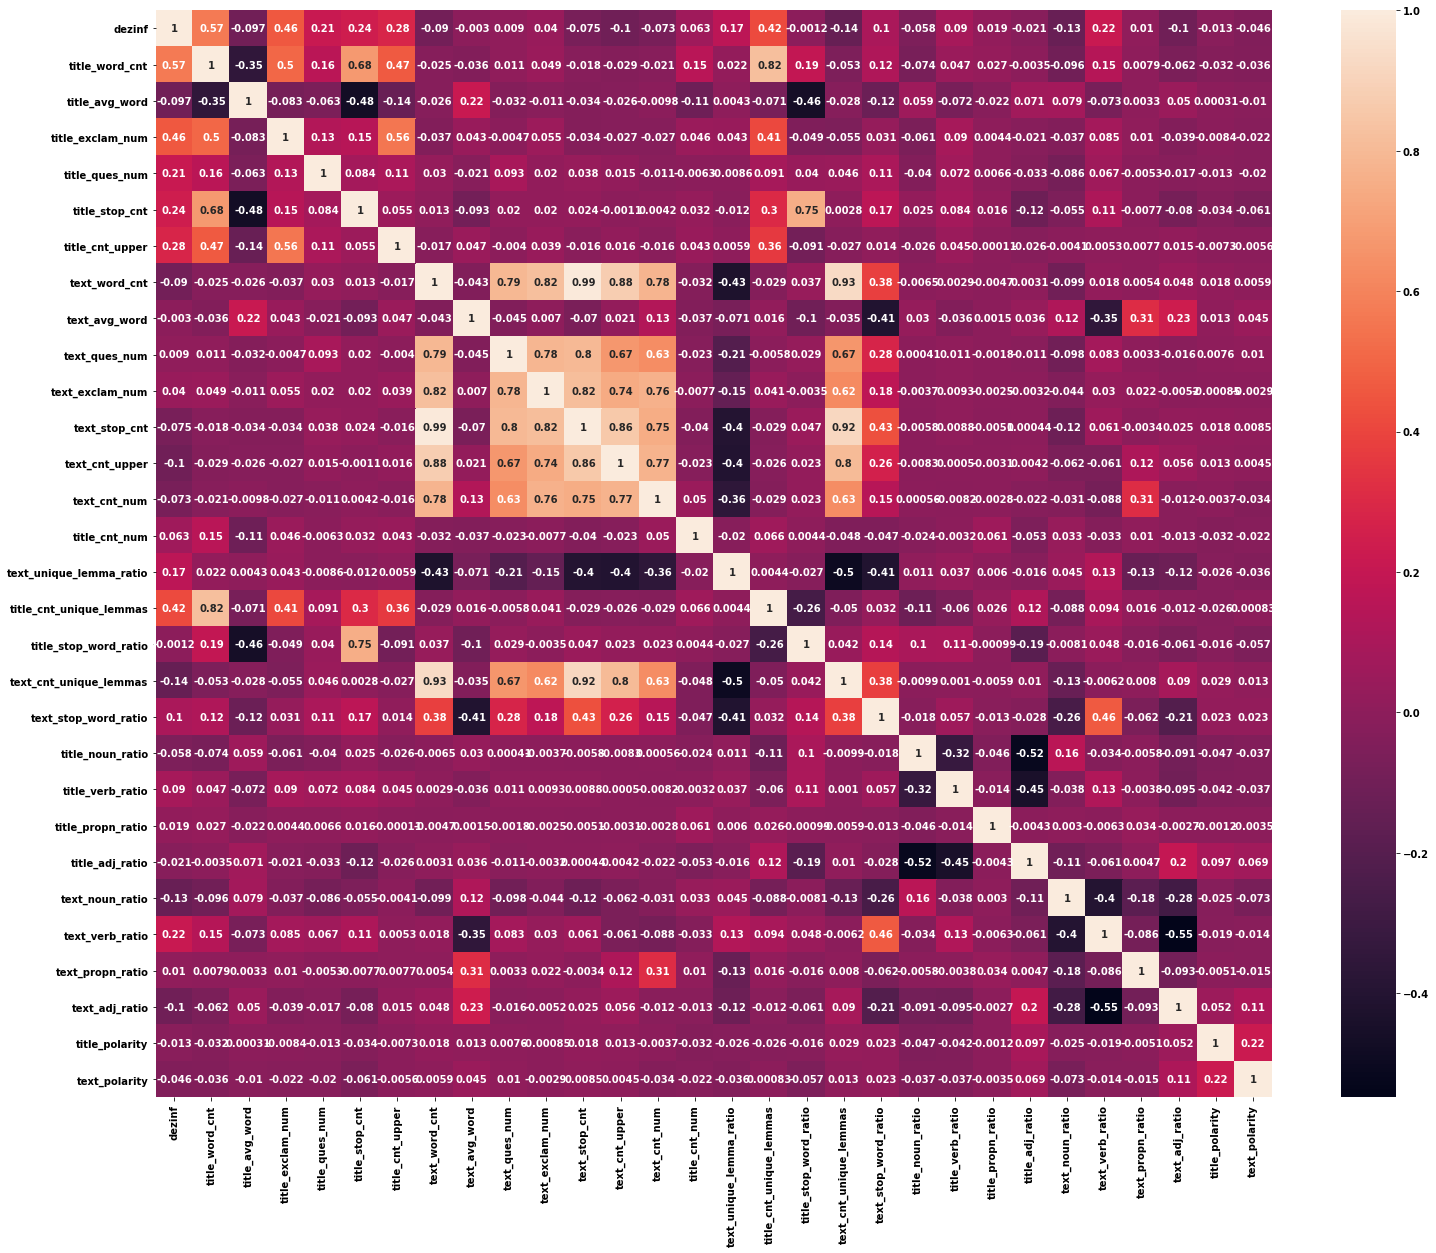

In [21]:
fig = plt.figure(figsize=(25, 20))
sns.heatmap(abt_covid_flat_vars.corr(), annot=True)

The heatmap can be used to visualize the correlation coefficients of continuous variables with a beautiful colourmap.

As the correlation heatmap shows there is multicollinearity in the data. <br> The multicollinearity occurs when features (input variables) are highly correlated with one or more of the other features in the dataset. <br> It affects the performance of regression and classification models.

### 6. Undersampling the majority class

The unbalance in the target feature affects the performance of classification models. <br>
The solution is undersampling the majority class (or oversampling the minority class, but it produces less accurate models)

In [22]:
class_count_0, class_count_1 = abt_covid_flat_vars['dezinf'].value_counts()

In [23]:
class_0 = abt_covid_flat_vars[abt_covid_flat_vars['dezinf'] == 0]
class_1 = abt_covid_flat_vars[abt_covid_flat_vars['dezinf'] == 1]
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (50356, 30)
class 1: (13275, 30)


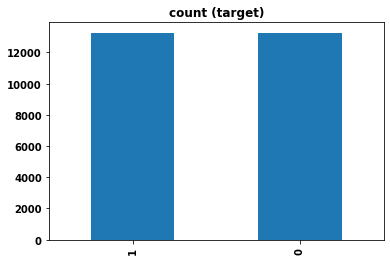

In [24]:
class_0_under = class_0.sample(class_count_1)

data_under = pd.concat([class_0_under, class_1], axis=0)

data_under['dezinf'].value_counts().plot(kind='bar', title='count (target)')

### 7. PCA on the undersampling data

The PCA is good for reduce the features in the training dataset (from 30 to 13).
On the other hand the PCA is necessarily for reduce the multicollinearity. <br>
The PCA combines the highly correlated variables into a set of uncorrelated variables.

In [32]:
X = data_under.loc[:, data_under.columns != 'dezinf']
y = data_under.loc[:, data_under.columns == 'dezinf']

#### 7.1 Create scree plot

Eigenvalues:
[5.58458067e+00 3.38742632e+00 2.44922056e+00 1.94405586e+00
 1.62915502e+00 1.35107987e+00 1.27537272e+00 1.17434041e+00
 1.12728754e+00 1.09775953e+00 1.04812982e+00 9.52578443e-01
 8.98070436e-01 7.95642725e-01 7.61710405e-01 6.00185547e-01
 5.16092562e-01 4.46096099e-01 4.04945520e-01 3.91896825e-01
 3.11013814e-01 2.29727051e-01 2.14913110e-01 1.40841325e-01
 1.05750034e-01 7.11812774e-02 5.31151750e-02 3.57340138e-02
 3.18965373e-03]

Variances (Percentage):
[1.92564494e+01 1.16803405e+01 8.44527003e+00 6.70338840e+00
 5.61756434e+00 4.65872061e+00 4.39767131e+00 4.04929717e+00
 3.88705200e+00 3.78523512e+00 3.61410462e+00 3.28462953e+00
 3.09667797e+00 2.74349227e+00 2.62648868e+00 2.06952738e+00
 1.77956250e+00 1.53820447e+00 1.39631127e+00 1.35131746e+00
 1.07242103e+00 7.92132409e-01 7.41051777e-01 4.85641450e-01
 3.64641553e-01 2.45443436e-01 1.83148877e-01 1.23216096e-01
 1.09983917e-02]



Text(0, 0.5, 'Explained variance (%)')

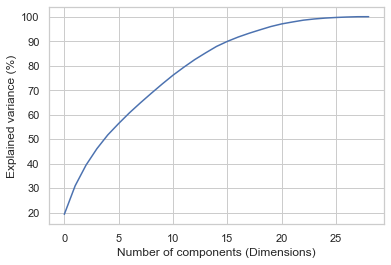

In [33]:
# apply the scaling on predictor features
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Apply PCA
pca = PCA(n_components=None)
pca.fit(X_scaled)

# Get the eigenvalues
print("Eigenvalues:")
print(pca.explained_variance_)
print()

# Get explained variances
print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)
print()

# Make the scree plot
sns.set(style="whitegrid")
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")

The above scree plot shows that almost the 85% of variance is explained by the first ~13 components. So in the next codeblock the n_component argument of the PCA function will be 13. 

#### 7.2 Fit the PCA based on scree plot

In [34]:
# PCA fit based on the scree plot
pca = PCA(n_components=13)
X_pca = pca.fit_transform(X_scaled)

# Get the transformed dataset
X_pca = pd.DataFrame(X_pca)
print(X_pca.head())
print("\nSize: ")
print(X_pca.shape)

          0         1         2         3         4         5         6  \
0 -1.187566 -2.375100 -0.417126  0.290466  2.519924 -0.112776 -0.619553   
1 -0.675206 -0.314506 -1.819172  1.332322  1.288460 -0.202156 -0.520018   
2 -0.702461 -0.583450 -0.388424 -0.992232 -0.097485  1.361261 -0.659587   
3 -0.711200  0.336937 -1.706015  0.667166  2.030824 -1.346436  0.022392   
4  0.051636 -0.358048 -0.326596  1.030745  0.017877  0.144595  0.028789   

          7         8         9        10        11        12  
0  0.119540 -0.402715  0.255917  0.222256 -0.104170  0.034813  
1  0.092088  0.270337 -0.606628  0.601465 -0.502778  0.266898  
2 -0.901367  0.494183 -0.171650 -0.622202 -0.212943  0.199395  
3  0.367147 -0.295465  0.381542 -0.021800 -0.251306  0.100403  
4 -0.375249 -0.136908 -0.244346 -0.641218  0.122128  0.401826  

Size: 
(26550, 13)


#### 7.3 Check the multicollinearity in the PCA components

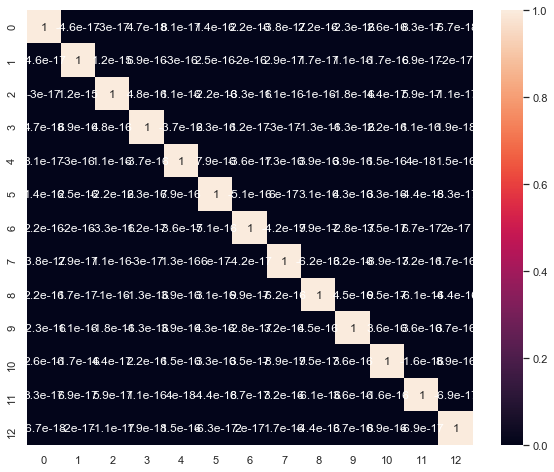

In [35]:
fig = plt.figure(figsize=(10, 8))
sns.heatmap(X_pca.corr(), 
            annot=True)

There is no any correlation between components. This is because PCA has transformed the set of correlated variables in the original dataset into a set of uncorrelated variables.

### 8. Building a logistic regression model on the transformed data

#### 8.1 Building the logistic regression on train/test split data

In [49]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2)

In [50]:
lr_model = LogisticRegression(penalty='l2', max_iter=2500, solver='lbfgs')
lr_model.fit(X_train_pca, y_train)

C:\Users\molna\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=2500)

#### 8.2 Get the modell coefficients

In [51]:
importance = lr_model.coef_[0]

In [52]:
for index, val in enumerate(importance):
    print("Feature : {} has score  : {} ".format(X_pca.columns[index], val))

Feature : 0 has score  : -0.2973054677817776 
Feature : 1 has score  : 1.567010359857376 
Feature : 2 has score  : 0.8164288096759577 
Feature : 3 has score  : -0.4559991616302097 
Feature : 4 has score  : 0.47117329419934356 
Feature : 5 has score  : 0.017283460308145857 
Feature : 6 has score  : 0.004632963218332262 
Feature : 7 has score  : 0.19765258567900448 
Feature : 8 has score  : -0.009275229838937688 
Feature : 9 has score  : -0.3844181830501538 
Feature : 10 has score  : 0.17014682295630337 
Feature : 11 has score  : 0.4304176386444585 
Feature : 12 has score  : -0.057591741192174035 


In [53]:
coeff_df = pd.DataFrame({'predictor': X_pca.columns, 'coefficient': importance}).sort_values(by=['coefficient'])

#### 8.3 Visualization of the modell coefficients

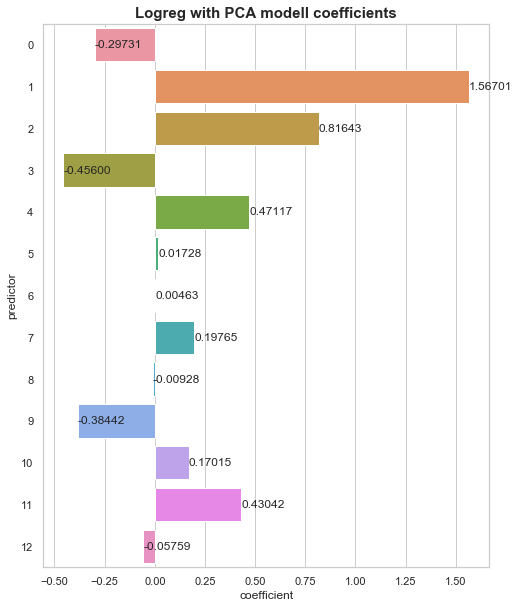

In [66]:
f, ax = plt.subplots(figsize=(8, 10))

sns.barplot(data=coeff_df, x='coefficient', y='predictor', orient='h')

plt.title('Logreg with PCA modell coefficients', fontweight='bold', fontsize=15)
plt.xlabel('coefficient', fontsize=12)
plt.ylabel('predictor', fontsize=12)

for p in ax.patches:
    width = p.get_width()   
    ax.text(width,       
            p.get_y() + p.get_height() / 2, 
            '{:1.5f}'.format(width), 
            ha = 'left',   
            va = 'center') 

#### 8.4 Evaulation of the modell

Make prediction with the modell

In [55]:
y_pred = lr_model.predict(X_test_pca)

Create the confusion matrix of the modell on y_test data

              precision    recall  f1-score   support

           0       0.79      0.87      0.82      2630
           1       0.85      0.77      0.81      2680

    accuracy                           0.82      5310
   macro avg       0.82      0.82      0.82      5310
weighted avg       0.82      0.82      0.82      5310



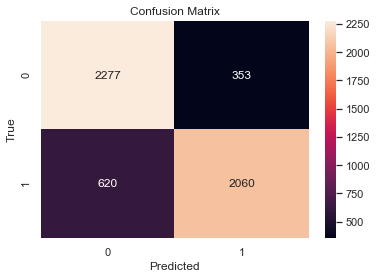

In [56]:
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
print(classification_report(y_test, y_pred))

**Precision: (positive predictive value)** <br>
Precision is the ratio of correctly predicted observations in the class. <br>
Of the predictions the model made for this class, what proportion were correct? <br>
<br>
dezinformational: The 85% of the dezinformational articles predicted correctly. <br>
mainstream: The 79% of the mainstream articles predicted correctly

**Recall: (sensitivity)** <br>
Recall is the ratio of correctly predicted positive observations to the all observations in actual class. <br>
Out of all of the instances of this class in the test dataset, how many did the model identify? <br>
<br>
dezinformational: The 87% of the dezinformational articles predicted correctly. <br>
mainstream: The 77% of the mainstream articles predicted correctly

**F1 Score:** <br> 
F1 score is the weighted average of Precision and Recall.

**Confusion matrix:** <br>
*True Positives:* These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes. <br>
*True Negatives:* These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no. <br>
*False Positives:* When actual class is no and predicted class is yes. <br>
*False Negatives:* When actual class is yes but predicted class in no.

The AUC score of the modell 

In [68]:
auc = round(roc_auc_score(y_test, y_pred), 6)
print("The accuracy score of the modell: {}".format(auc))

The accuracy score of the modell: 0.817218


The auc/roc curve of the modell

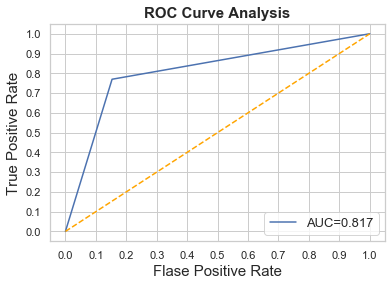

In [137]:
plt.plot(fpr, tpr, label="AUC={:.3f}".format(auc))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

### 9. Logistic regression without PCA

In [77]:
X = data_under.loc[:, data_under.columns != 'dezinf']
y = data_under.loc[:, data_under.columns == 'dezinf']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [87]:
lr_model = LogisticRegression(penalty='l2', max_iter=5000, solver='lbfgs')
lr_model.fit(X_train, y_train)

C:\Users\molna\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\molna\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(max_iter=5000)

In [88]:
importance = lr_model.coef_[0]

In [90]:
for index, val in enumerate(importance):
    print("Feature : {} has score  : {} ".format(X.columns[index], val))

Feature : title_word_cnt has score  : 2.0483084863205057 
Feature : title_avg_word has score  : 0.552918966167995 
Feature : title_exclam_num has score  : 3.772088715016339 
Feature : title_ques_num has score  : 1.14875039044886 
Feature : title_stop_cnt has score  : -1.7610622227946051 
Feature : title_cnt_upper has score  : -0.5578996103159675 
Feature : text_word_cnt has score  : -0.0051580109331277185 
Feature : text_avg_word has score  : 0.10085364668475444 
Feature : text_ques_num has score  : 0.03911933747133426 
Feature : text_exclam_num has score  : 0.22481577305934797 
Feature : text_stop_cnt has score  : 0.010535670255376108 
Feature : text_cnt_upper has score  : 0.00714659500585453 
Feature : text_cnt_num has score  : -0.0012404073511059707 
Feature : title_cnt_num has score  : -0.4196765338179677 
Feature : text_unique_lemma_ratio has score  : 2.0729716912009972 
Feature : title_cnt_unique_lemmas has score  : -1.6302690688597086 
Feature : title_stop_word_ratio has score  

In [91]:
y_pred = lr_model.predict(X_test)

In [92]:
coeff_df = pd.DataFrame({'predictor': X.columns, 'coefficient': importance}).sort_values(by=['coefficient'])

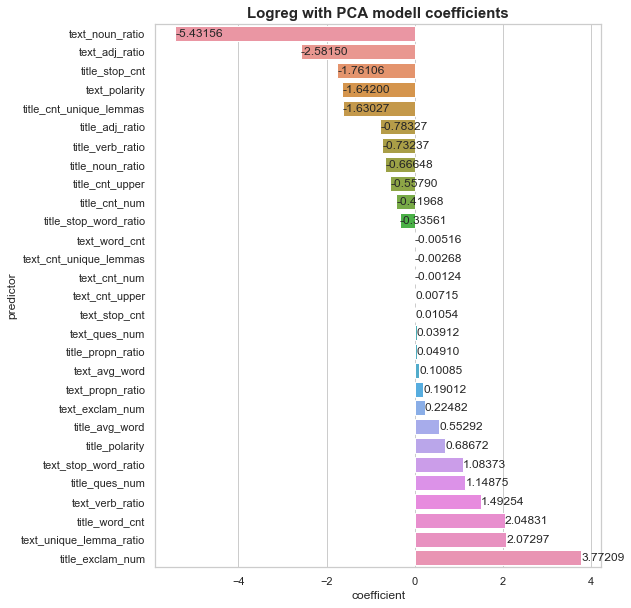

In [93]:
f, ax = plt.subplots(figsize=(8, 10))

sns.barplot(data=coeff_df, x='coefficient', y='predictor', orient='h')

plt.title('Logreg with PCA modell coefficients', fontweight='bold', fontsize=15)
plt.xlabel('coefficient', fontsize=12)
plt.ylabel('predictor', fontsize=12)

for p in ax.patches:
    width = p.get_width()   
    ax.text(width,       
            p.get_y() + p.get_height() / 2, 
            '{:1.5f}'.format(width), 
            ha = 'left',   
            va = 'center') 

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2686
           1       0.93      0.89      0.91      2624

    accuracy                           0.91      5310
   macro avg       0.91      0.91      0.91      5310
weighted avg       0.91      0.91      0.91      5310



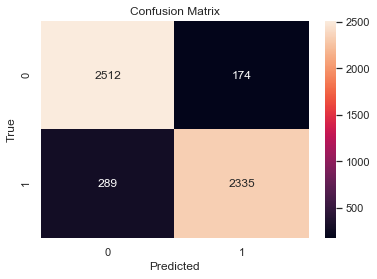

In [94]:
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
print(classification_report(y_test, y_pred))

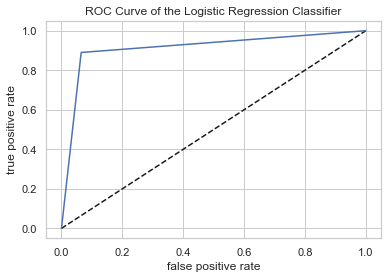

The AUC score of the Logistic Regression Classifier: 0.91


In [95]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# plot the diagonal line
plt.plot([0,1],[0,1],'k--') 
# plot the ROC curve
plt.plot(fpr, tpr, label='NB') 
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC Curve of the Logistic Regression Classifier')
plt.show()

print("The AUC score of the Logistic Regression Classifier: {}".format(round(roc_auc_score(y_test, y_pred), 2)))

### 10. Logistic regression without PCA and with significant variables

In [96]:
sig_vars = ["title_word_cnt", "title_exclam_num", "title_ques_num", "title_stop_cnt", 
            "title_cnt_upper", "text_cnt_num", "text_unique_lemma_ratio", "title_cnt_unique_lemmas",
            "title_stop_word_ratio", "title_noun_ratio", "title_verb_ratio", "title_adj_ratio",
            "text_noun_ratio", "text_adj_ratio", "title_polarity", "text_polarity", "dezinf"]

In [97]:
abt_covid_sig = data_under[sig_vars]

In [98]:
calculate_vif(abt_covid_sig.iloc[:,:-1])

,variables,VIF
0,title_word_cnt,92.061909
1,title_exclam_num,1.986437
2,title_ques_num,1.120215
3,title_stop_cnt,30.676350
4,title_cnt_upper,2.565573
5,text_cnt_num,1.210121
6,text_unique_lemma_ratio,60.699384
7,title_cnt_unique_lemmas,63.194452
8,title_stop_word_ratio,17.185977
9,title_noun_ratio,28.743454


In [99]:
sig_vars_antimulti = abt_covid_sig.drop(["text_noun_ratio", "text_unique_lemma_ratio", "title_cnt_unique_lemmas",
                                        "title_word_cnt", "text_adj_ratio"], axis=1)

In [100]:
sig_vars_antimulti = abt_covid_sig.drop(["text_noun_ratio", "text_unique_lemma_ratio", "title_cnt_unique_lemmas",
                                        "title_stop_word_ratio", "title_stop_cnt", "text_adj_ratio"], axis=1)

In [101]:
calculate_vif(sig_vars_antimulti.iloc[:,:-1])

,variables,VIF
0,title_word_cnt,8.709060
1,title_exclam_num,1.928713
2,title_ques_num,1.112207
3,title_cnt_upper,1.793740
4,text_cnt_num,1.101767
5,title_noun_ratio,4.941693
6,title_verb_ratio,2.733667
7,title_adj_ratio,2.616068
8,title_polarity,1.180752
9,text_polarity,1.258332


In [102]:
X = sig_vars_antimulti.loc[:, sig_vars_antimulti.columns != 'dezinf']
y = sig_vars_antimulti.loc[:, sig_vars_antimulti.columns == 'dezinf']

In [103]:
logit_model = sm.Logit(y, X)
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.394522
         Iterations 9


In [104]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 dezinf   No. Observations:                26550
Model:                          Logit   Df Residuals:                    26540
Method:                           MLE   Df Model:                            9
Date:                Sat, 22 Jan 2022   Pseudo R-squ.:                  0.4308
Time:                        14:34:32   Log-Likelihood:                -10475.
converged:                       True   LL-Null:                       -18403.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
title_word_cnt       0.3883      0.006     62.702      0.000       0.376       0.400
title_exclam_num     3.3460      0.097     34.662      0.000       3.157       3.535
title_ques_num       1.5543      0.077     20.226      0.000       1.404       1.705
title_cnt_upper     -0.0605      0.025     -2.402      0.016      -0.110      -0.011
text_cnt_num        -0.0177      0.001    -26.953      0.000      -0.019      -0.016
title_noun_ratio    -4.3471      0.084    -51.941      0.000      -4.511      -4.183
title_verb_ratio    -4.2294      0.139    -30.460      0.000      -4.502      -3.957
title_adj_ratio     -4.1539      0.109    -38.158      0.000      -4.367      -3.941
title_polarity       0.9076      0.266      3.409      0.001       0.386       1.429
text_polarity       -8.9235      1.030     -8.663      0.000     -10.942      -6.905
====================================================================================
"""

### 10.1 Logistic Regression with Sklearn

In [105]:
X = sig_vars_antimulti.loc[:, sig_vars_antimulti.columns != 'dezinf']
y = sig_vars_antimulti.loc[:, sig_vars_antimulti.columns == 'dezinf']

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [107]:
lr_model = LogisticRegression(penalty='l2', max_iter=2500, solver='lbfgs')
lr_model.fit(X_train, y_train)

C:\Users\molna\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=2500)

In [108]:
importance = lr_model.coef_[0]

In [109]:
for index, val in enumerate(importance):
    print("Feature : {} has score  : {} ".format(X.columns[index], val))

Feature : title_word_cnt has score  : 0.4644390549875747 
Feature : title_exclam_num has score  : 3.405060201248758 
Feature : title_ques_num has score  : 1.609441256676677 
Feature : title_cnt_upper has score  : -0.0420058067305458 
Feature : text_cnt_num has score  : -0.016979869382020174 
Feature : title_noun_ratio has score  : 0.4649978318784429 
Feature : title_verb_ratio has score  : 1.1710657271841696 
Feature : title_adj_ratio has score  : 0.46161873586188273 
Feature : title_polarity has score  : 0.7203607443606159 
Feature : text_polarity has score  : -3.4442027886149806 


In [110]:
coeff_df = pd.DataFrame({'predictor': X.columns, 'coefficient': importance}).sort_values(by=['coefficient'])

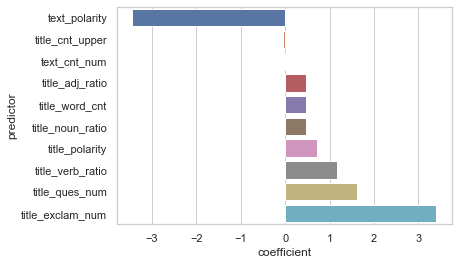

In [111]:
sns.barplot(data=coeff_df, x='coefficient', y='predictor', orient='h')

In [112]:
y_pred = lr_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      2649
           1       0.87      0.78      0.82      2661

    accuracy                           0.83      5310
   macro avg       0.84      0.83      0.83      5310
weighted avg       0.84      0.83      0.83      5310



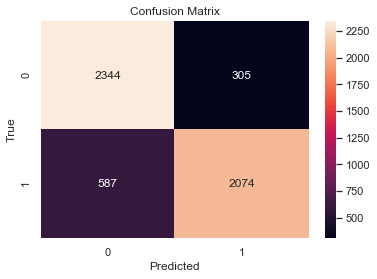

In [113]:
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
print(classification_report(y_test, y_pred))

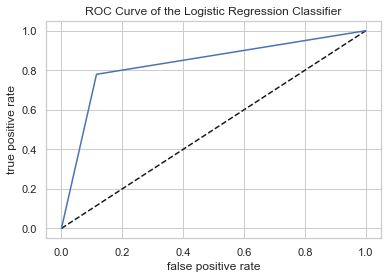

The AUC score of the Logistic Regression Classifier: 0.83


In [114]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# plot the diagonal line
plt.plot([0,1],[0,1],'k--') 
# plot the ROC curve
plt.plot(fpr, tpr, label='NB') 
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC Curve of the Logistic Regression Classifier')
plt.show()

print("The AUC score of the Logistic Regression Classifier: {}".format(round(roc_auc_score(y_test, y_pred), 2)))